In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import random

In [2]:
N_SAMPLES = 5500

data = {
    "customer_age": np.random.randint(18, 65, N_SAMPLES),
    "monthly_income": np.random.randint(15000, 150000, N_SAMPLES),
    "purchase_frequency": np.random.randint(1, 30, N_SAMPLES),
    "avg_order_value": np.random.randint(300, 5000, N_SAMPLES),
    "marketing_spend": np.random.randint(500, 20000, N_SAMPLES),
    "region_score": np.random.uniform(0.5, 1.5, N_SAMPLES),
}

df = pd.DataFrame(data)

In [4]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [5]:
df["sales_success"] = (
    (df["purchase_frequency"] * df["avg_order_value"] +
     df["marketing_spend"] * df["region_score"]) >
    np.percentile(
        df["purchase_frequency"] * df["avg_order_value"], 60
    )
).astype(int)

df.head()

,customer_age,monthly_income,purchase_frequency,avg_order_value,marketing_spend,region_score,sales_success
0,63,146438,5,3130,13600,0.622556,0
1,27,112433,18,1036,8014,0.557801,0
2,37,50412,11,1702,11445,1.484353,0
3,33,86088,10,2004,12974,0.614235,0
4,39,16395,17,1898,9444,0.797637,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_age        5500 non-null   int32  
 1   monthly_income      5500 non-null   int32  
 2   purchase_frequency  5500 non-null   int32  
 3   avg_order_value     5500 non-null   int32  
 4   marketing_spend     5500 non-null   int32  
 5   region_score        5500 non-null   float64
 6   sales_success       5500 non-null   int32  
dtypes: float64(1), int32(6)
memory usage: 172.0 KB


In [7]:
df.isnull().sum()

customer_age          0
monthly_income        0
purchase_frequency    0
avg_order_value       0
marketing_spend       0
region_score          0
sales_success         0
dtype: int64

In [8]:
df.describe()

,customer_age,monthly_income,purchase_frequency,avg_order_value,marketing_spend,region_score,sales_success
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,40.967273,82516.153818,15.146182,2608.776909,10255.202182,0.996882,0.516000
std,13.627618,38721.029074,8.309267,1349.146786,5602.904507,0.287166,0.499789
min,18.000000,15035.000000,1.000000,300.000000,501.000000,0.500185,0.000000
25%,29.000000,49420.750000,8.000000,1445.000000,5399.000000,0.751668,0.000000
50%,41.000000,82495.500000,15.000000,2600.500000,10240.500000,0.990839,1.000000
75%,53.000000,115688.250000,22.000000,3740.000000,15105.000000,1.242832,1.000000
max,64.000000,149997.000000,29.000000,4999.000000,19997.000000,1.499121,1.000000


In [9]:
X = df.drop("sales_success", axis=1)
y = df["sales_success"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [11]:
baseline_model = LogisticRegression(random_state=RANDOM_STATE)
baseline_model.fit(X_train, y_train)

y_pred_base = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_base)

baseline_acc

0.9154545454545454

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=RANDOM_STATE
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_acc

0.9618181818181818

In [13]:
improvement = ((rf_acc - baseline_acc) / baseline_acc) * 100
improvement

5.064548162859983

In [14]:
cv_scores = cross_val_score(
    rf_model, X_scaled, y, cv=5, scoring="accuracy"
)

cv_scores.mean(), cv_scores.std()

(0.9645454545454545, 0.0035906213923875404)

In [15]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       532
           1       0.97      0.96      0.96       568

    accuracy                           0.96      1100
   macro avg       0.96      0.96      0.96      1100
weighted avg       0.96      0.96      0.96      1100



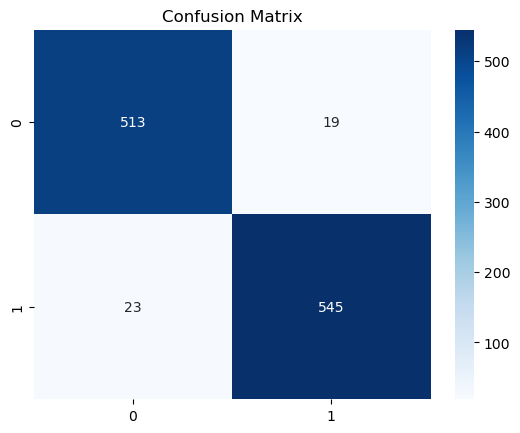

In [16]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [17]:
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
2,purchase_frequency,0.460135
3,avg_order_value,0.422098
4,marketing_spend,0.051402
5,region_score,0.034713
1,monthly_income,0.018025
0,customer_age,0.013627
